In [22]:
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Embedding, Activation, Bidirectional, LSTM,Conv1D,MaxPooling1D
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
import re
import nltk
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [6]:
import pandas as pd
import os,random,math
TRAINING_DIR="propaganda_dataset_v2"
files=os.listdir(TRAINING_DIR)
#since we have just two files we dont need loops
traindf= pd.read_csv(os.path.join(TRAINING_DIR,files[0]),sep = '\t')
testdf= pd.read_csv(os.path.join(TRAINING_DIR,files[1]),sep = '\t')

In [7]:
def convert_text(sentences):
    start_sent = sentences.replace("<BOS>","")
    end_sent =start_sent.replace("<EOS>","")
    return end_sent

In [8]:
testdf["tagged_in_context"]=testdf["tagged_in_context"].map(convert_text)
traindf["tagged_in_context"]=traindf["tagged_in_context"].map(convert_text)

In [9]:
two_class_traindf=traindf
two_class_testdf=testdf

In [10]:
def convert_labels(label):
    return 1 if label=="not_propaganda" else 0
two_class_testdf["label"]= two_class_testdf["label"].map(convert_labels)
two_class_traindf["label"]=two_class_traindf["label"].map(convert_labels)
two_class_traindf

,label,tagged_in_context
0,1,"No, he will not be confirmed."
1,1,This declassification effort won’t make thing...
2,0,The Obama administration misled the American ...
3,1,“It looks like we’re capturing the demise of t...
4,1,"Location: Westerville, Ohio"
...,...,...
2409,1,We support and appreciate your business.”
2410,1,International Atomic Energy Agency (IAEA) Dire...
2411,1,What has been done: there has been work on for...
2412,1,This is the law of gradualness not the gradua...


In [12]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    stops = stopwords.words('english')
    #print(stops)
    
    return sentence.lower()

In [13]:
two_class_testdf["tagged_in_context"]=two_class_testdf["tagged_in_context"].map(preprocess_text)
two_class_traindf["tagged_in_context"]=two_class_traindf["tagged_in_context"].map(preprocess_text)

In [14]:
from keras.utils import to_categorical
y_train = to_categorical(two_class_traindf["label"])
y_test = to_categorical(two_class_testdf["label"])

In [15]:
from keras.preprocessing.text import Tokenizer
no_words=10000
tokenizer=Tokenizer(num_words=no_words,lower=True)

In [16]:
mes = []
for i in two_class_testdf['tagged_in_context']:
    mes.append(i.split())
for i in two_class_traindf['tagged_in_context']:
    mes.append(i.split())

In [17]:
tokenizer.fit_on_texts(mes)

In [18]:
X_train=tokenizer.texts_to_sequences(two_class_traindf["tagged_in_context"]) # this converts texts into some numeric sequences 
X_train_pad=pad_sequences(X_train,maxlen=140,padding='post') # this makes the length of all numeric sequences equal 
X_test = tokenizer.texts_to_sequences(two_class_testdf["tagged_in_context"])
X_test_pad = pad_sequences(X_test, maxlen = 140, padding = 'post')

In [19]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100')

In [20]:
vector_size = 100
gensim_weight_matrix = np.zeros((no_words ,vector_size))
gensim_weight_matrix.shape
words = list(glove_gensim.key_to_index.keys())
for word, index in tokenizer.word_index.items():
    if index < no_words: # since index starts with zero 
        if word in  words:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [26]:
# create the model
EMBEDDING_DIM = 100
class_num = 2
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(input_dim = no_words,
 output_dim = EMBEDDING_DIM,
 input_length= X_train_pad.shape[1],
 weights = [gensim_weight_matrix],trainable = False))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 140, 100)          1000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 140, 32)           9632      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 70, 32)           0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 100)               53200     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 1,063,034
Trainable params: 63,034
Non-trainable params: 1,000,000
_______________________________________

In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./CNNLASTMmodel.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [28]:
history_embedding = model.fit(X_train_pad, y_train, 
                                epochs = 25, batch_size = 120, 
                                validation_data=(X_test_pad, y_test),
                                verbose = 1, callbacks= [es, mc]  )

Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 0.6919 - accuracy: 0.4959
Epoch 1: val_accuracy improved from -inf to 0.48103, saving model to .\CNNLASTMmodel.h5
21/21 [==============================] - 16s 66ms/step - loss: 0.6919 - accuracy: 0.4959 - val_loss: 0.6953 - val_accuracy: 0.4810
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5244
Epoch 2: val_accuracy improved from 0.48103 to 0.52759, saving model to .\CNNLASTMmodel.h5
21/21 [==============================] - 1s 51ms/step - loss: 0.6896 - accuracy: 0.5244 - val_loss: 0.6916 - val_accuracy: 0.5276
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 0.6887 - accuracy: 0.5369
Epoch 3: val_accuracy did not improve from 0.52759
21/21 [==============================] - 1s 45ms/step - loss: 0.6887 - accuracy: 0.5369 - val_loss: 0.6939 - val_accuracy: 0.4983
Epoch 4/25
20/21 [===========================>..] - ETA: 0s - loss: 0.6568 - accuracy: 0.6125
Epo

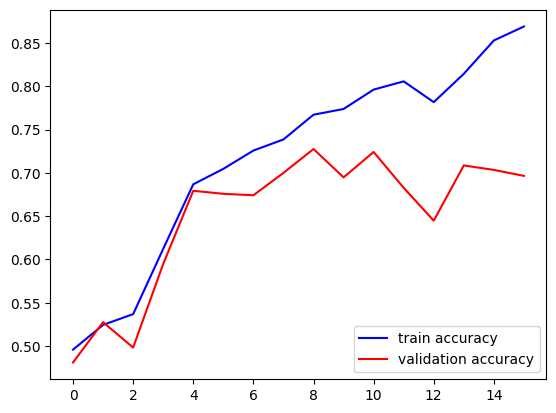

In [29]:
import matplotlib.pyplot as plt
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [30]:
y_pred =   np.argmax(model.predict(X_test_pad), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

19/19 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.56      0.75      0.64       209
           1       0.82      0.67      0.74       371

    accuracy                           0.70       580
   macro avg       0.69      0.71      0.69       580
weighted avg       0.73      0.70      0.70       580

